In [53]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [52]:
import pandas as pd
dataset = pd.read_csv('/content/drive/MyDrive/dataset.csv')

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 54.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 52.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 31.2 MB/s eta 0:00:00


In [63]:
!pip install torchtext==0.6.0



In [ ]:
!pip install spacy

In [ ]:
import os
import numpy as np # linear algebra
import pandas as pd
# Provide the path to your directory
directory_path = '/content/drive/MyDrive/training.1600000.processed.noemoticon.csv'

for dirname, _, filenames in os.walk(directory_path):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
import warnings
warnings.filterwarnings("ignore")
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split

In [68]:
df = pd.read_csv('/content/drive/MyDrive/training.1600000.processed.noemoticon.csv', encoding = 'latin',header=None)
df.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']
df = df.drop(['id', 'date', 'query', 'user_id'], axis=1)
df.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [ ]:
df.sentiment = df.sentiment.map({0:0,4:1})

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stop_words = set(stopwords.words('english'))
def data_preprocessing(text):
    text = text.lower()
    text = re.sub('<.*?>', '', text) # Remove HTML from text
    text = ''.join([c for c in text if c not in string.punctuation])# Remove punctuation
    text = [word for word in text.split() if word not in stop_words]
    text = ' '.join(text)
    return text

df['text'] = df['text'].astype(str).apply(data_preprocessing)
df.head()

,sentiment,text
0,0,switchfoot httptwitpiccom2y1zl awww thats bumm...
1,0,upset cant update facebook texting might cry r...
2,0,kenichan dived many times ball managed save 50...
3,0,whole body feels itchy like fire
4,0,nationwideclass behaving im mad cant see


In [ ]:
MAX_LEN = max([len(x.split()) for x in df['text']])
print(MAX_LEN)

38


In [ ]:
import torch

class Dataset:
    def __init__(self,text,sentiment):
        self.text = text
        self.sentiment = sentiment

    def __len__(self):
        return len(self.text)

    def __getitem__(self,item):
        text = self.text[item,:]
        target = self.sentiment[item]
        return {
            "text": torch.tensor(text,dtype = torch.long),
            "target": torch.tensor(target,dtype = torch.long)
        }

In [ ]:
def load_vectors(fname):
    fin = open(fname)
    data = {}
    for line in fin:
        tokens = line.split()
        data[tokens[0]] = np.array([float(value) for value in tokens[1:]])

    return data

In [ ]:
def create_embedding_matrix(word_index,embedding_dict):
    """
    This function creates the embedding matrix
    :param word_index: a dictionary of word: index_value
    :param embedding_dict:
    :return a numpy array with embedding vectors for all known words
    """
    # intialize the embedding matrix
    embedding_matrix = np.zeros((len(word_index)+1,300))
    for word, i in word_index.items():
        if word in embedding_dict:
            embedding_matrix[i] = embedding_dict[word]
    return embedding_matrix

In [ ]:
class sentimentBiLSTM(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """

    def __init__(self, embedding_matrix, hidden_dim, output_size):
        """
        Initialize the model by setting up the layers.
        """
        super(sentimentBiLSTM, self).__init__()
        self.embedding_matrix = embedding_matrix
        self.hidden_dim = hidden_dim
        num_words = self.embedding_matrix.shape[0]
        embed_dim = self.embedding_matrix.shape[1]
        self.embedding = nn.Embedding(num_embeddings=num_words,embedding_dim=embed_dim)
        ## initializes the weights of the embedding layer to the pretrained embeddings in
        ## embedding_matrix. It first converts embedding_matrix to a PyTorch tensor and
        ## wraps it in an nn.Parameter object, which makes it a learnable parameter of the model.
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix,dtype=torch.float32))
        self.embedding.weight.requires_grad = False


#         self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, batch_first=True)
        self.lstm = nn.LSTM(embed_dim,hidden_dim,bidirectional=True,batch_first=True)
#         self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim*2, output_size)
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        batch_size = x.size(0)

        #embedding and lstm_out
        embeds = self.embedding(x)

        lstm_out, _ = self.lstm(embeds)
#         lstm_out = self.dropout(lstm_out)
        #stack up lstm outputs
#         lstm_out = lstm_out[ : , -1, : ]   # (batch_size, hidden_dim)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim*2) # (batch_size*seq_len, hidden_dim) all time steps
        out = self.fc(lstm_out)

        #sigmoid function
        sig_out = self.sigmoid(out)

        # reshape to be batch size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # get last batch of labels

        return sig_out

In [ ]:
from sklearn.model_selection import train_test_split
y = df.sentiment.values
train_df,test_df = train_test_split(df,test_size = 0.2, stratify = y)
import tensorflow as tf

BATCH_SIZE = 16

print('Fitting tokenizer')
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(df.text.values.tolist())



xtrain = tokenizer.texts_to_sequences(train_df.text.values)
xtest = tokenizer.texts_to_sequences(test_df.text.values)
xtrain = tf.keras.preprocessing.sequence.pad_sequences(xtrain,maxlen = MAX_LEN)
xtest = tf.keras.preprocessing.sequence.pad_sequences(xtest,maxlen = MAX_LEN)
train_dataset = Dataset(text=xtrain,sentiment=train_df.sentiment.values)
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=BATCH_SIZE,drop_last=True)
valid_dataset = Dataset(text=xtest,sentiment=test_df.sentiment.values)
valid_loader = torch.utils.data.DataLoader(valid_dataset,batch_size=BATCH_SIZE,drop_last=True)

Fitting tokenizer


In [54]:
embedding_dict = load_vectors('/content/drive/MyDrive/glove.6B.300d.txt')
embedding_matrix = create_embedding_matrix(tokenizer.word_index,embedding_dict)
print("Embeddings loaded")

Embeddings loaded


In [55]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

# Instantiate the model w/ hyperparams
hidden_dim = 64
output_size = 1

model = sentimentBiLSTM(embedding_matrix, hidden_dim, output_size)
model = model.to(device)

print(model)

GPU is available
sentimentBiLSTM(
  (embedding): Embedding(850023, 300)
  (lstm): LSTM(300, 64, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [56]:
from torch import optim

# weight_decay =1e-4
# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay= weight_decay)
optimizer = optim.Adam(model.parameters(), lr=0.001)

criterion = nn.BCELoss()

def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [60]:
import time
clip = 5
epochs = 5
valid_loss_min = np.Inf
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    start_time = time.time()
    train_losses = []
    train_acc = 0.0
    model.train()
    correct = 0
    # initialize hidden state
    for data in train_loader:
        inputs = data['text']
        labels = data['target']
        inputs = inputs.to(device,dtype=torch.long)
        labels = labels.to(device,dtype=torch.float)
        model.zero_grad()
        output = model(inputs)

        # calculate the loss and perform backprop
        loss = criterion(output, labels)
        loss.backward()
        train_losses.append(loss.item())
        # accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy
        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()


    val_losses = []
    val_acc = 0.0
    model.eval()
    for data in valid_loader:
        inputs = data['text']
        labels = data['target']
        inputs = inputs.to(device,dtype=torch.long)
        labels = labels.to(device,dtype=torch.float)
        model.zero_grad()
        output = model(inputs)

        output = model(inputs)
        val_loss = criterion(output, labels)

        val_losses.append(val_loss.item())

        accuracy = acc(output,labels)
        val_acc += accuracy

    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}')
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    if epoch_val_loss <= valid_loss_min:
        torch.save(model.state_dict(), '/content/drive/MyDrive/Working/state_dict.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print("Duration:", time.time()-start_time)
    print(25*'==')

Epoch 1
train_loss : 0.4369250467600301 val_loss : 0.44697478211000563
train_accuracy : 79.498984375 val_accuracy : 78.9259375
Validation loss decreased (inf --> 0.446975).  Saving model ...
Duration: 273.62012815475464
Epoch 2
train_loss : 0.42668949201386425 val_loss : 0.44858784428946674
train_accuracy : 80.1184375 val_accuracy : 78.88312499999999
Duration: 270.30559396743774
Epoch 3
train_loss : 0.41939698078725485 val_loss : 0.450476361207664
train_accuracy : 80.547265625 val_accuracy : 78.865625
Duration: 270.584166765213
Epoch 4
train_loss : 0.4138979161928408 val_loss : 0.4519121181495488
train_accuracy : 80.859453125 val_accuracy : 78.74562499999999
Duration: 271.2071907520294
Epoch 5
train_loss : 0.40942488453853876 val_loss : 0.4540370997268707
train_accuracy : 81.097421875 val_accuracy : 78.6346875
Duration: 269.33249831199646


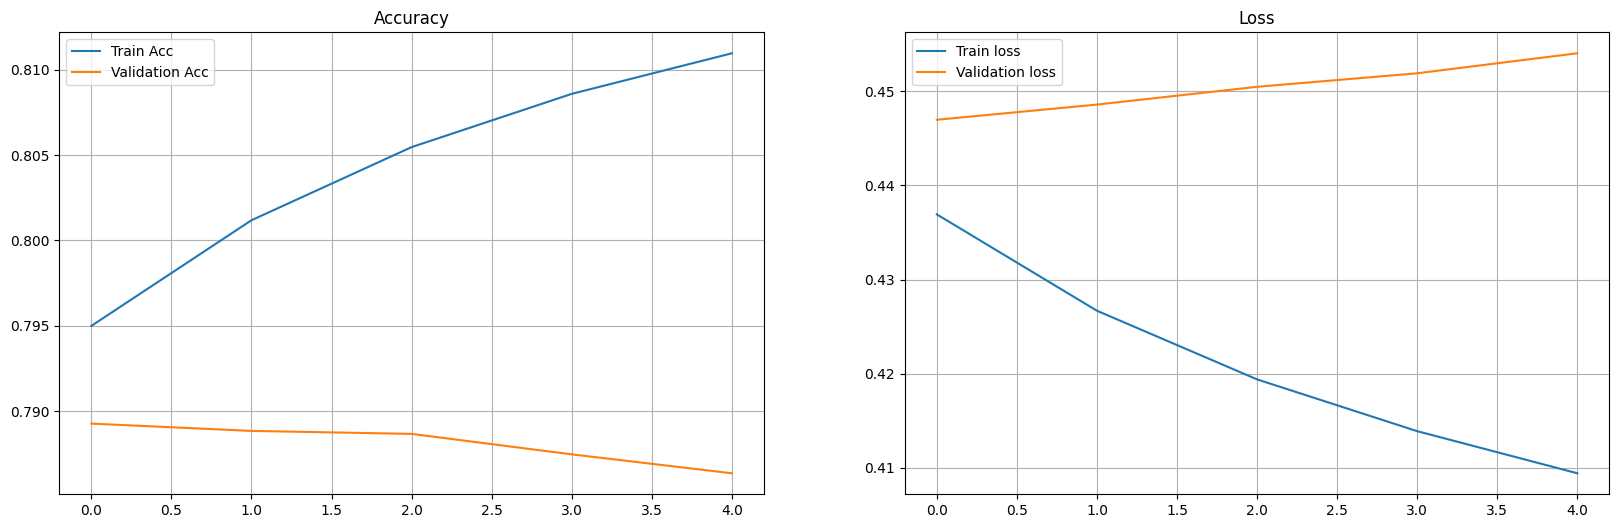

In [61]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

In [74]:
import pandas as pd
import torch
from torch import nn, optim
from torchtext import data
from torchtext.vocab import GloVe
import html  # Import the html library for decoding HTML entities
import spacy

# Load your dataset from the CSV file
df_small = pd.read_csv('/content/drive/MyDrive/dataset.csv')

# Create a spaCy tokenizer
nlp = spacy.load("en_core_web_sm", disable=["parser", "tagger", "ner"])

# Define a custom tokenizer function to handle decoding and tokenization
def custom_tokenizer(text):
    decoded_text = html.unescape(text)
    tokens = [tok.text for tok in nlp(decoded_text)]
    return tokens

# Define the text and label fields
TEXT = data.Field(
    sequential=True,
    tokenize=custom_tokenizer,
    lower=True,
    include_lengths=True,
    fix_length=100  # Specify the maximum length of your text
)
LABEL = data.LabelField(dtype=torch.float)

# Create examples from your DataFrame
examples = [data.Example.fromlist([html.unescape(text), label], fields=[('text', TEXT), ('label', LABEL)]) for text, label in zip(df_small['text'], df_small['label'])]

# Create a Dataset
dataset = data.Dataset(examples, fields=[('text', TEXT), ('label', LABEL)])

# Split the dataset
train_data, temp_data = dataset.split(split_ratio=0.8)
val_data, test_data = temp_data.split(split_ratio=0.5)

# Build the vocabulary
TEXT.build_vocab(train_data, max_size=20000, vectors=GloVe(name="6B", dim=300))
LABEL.build_vocab(train_data)

# Create iterators for the datasets
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 16
train_iter, val_iter, test_iter = data.BucketIterator.splits(
    (train_data, val_data, test_data),
    batch_size=batch_size,
    sort_within_batch=True,
    sort_key=lambda x: len(x.text),
    device=device,
)

# Define the LSTM-based text classification model
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super(LSTMClassifier, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text, text_lengths):
      embedded = self.dropout(self.embedding(text))
      text_lengths = text_lengths.cpu()  # Move the lengths tensor to the CPU
      packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)
      packed_output, (hidden, cell) = self.lstm(packed_embedded)
      output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
      hidden = self.dropout(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1) if self.lstm.bidirectional else hidden[-1, :, :])
      return self.fc(hidden)


# Hyperparameters
vocab_size = len(TEXT.vocab)
embedding_dim = 300
hidden_dim = 100
output_dim = 1  # For binary classification
n_layers = 2
bidirectional = True
dropout = 0.4

# Initialize the model
model = LSTMClassifier(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout)

# Set the optimizer and loss function
optimizer = optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()

# Move the model to the appropriate device
model = model.to(device)

# Training loop
def train_model(
    model,
    train_iter,
    val_iter,
    optimizer,
    criterion=nn.BCEWithLogitsLoss(),
    epochs=10,
    early_stopping=False,
    patience=4,
):
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    if early_stopping:
        patience_count = 0
        best_val_loss = float("inf")

    for epoch in range(1, epochs + 1):
        train_loss = 0.0
        train_acc = 0.0
        model.train()

        for batch in train_iter:
            optimizer.zero_grad()
            text, text_lengths = batch.text
            labels = batch.label
            predictions = model(text, text_lengths).squeeze(1)
            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_acc += binary_accuracy(predictions, labels)

        train_loss /= len(train_iter)
        train_acc /= len(train_iter)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        val_loss, val_acc = evaluate_model(model, val_iter, criterion)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(
            f"Epoch: {epoch}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
        )

        if early_stopping:
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_count = 0
            else:
                patience_count += 1
                if patience_count >= patience:
                    print("Early stopping. Patience limit reached.")
                    break

    return train_losses, val_losses, train_accs, val_accs

def evaluate_model(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0

    with torch.no_grad():
        for batch in iterator:
            text, text_lengths = batch.text
            labels = batch.label
            predictions = model(text, text_lengths).squeeze(1)
            loss = criterion(predictions, labels)
            acc = binary_accuracy(predictions, labels)
            epoch_loss += loss.item()
            epoch_acc += acc

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

# Train the model
train_model(
    model,
    train_iter,
    val_iter,
    optimizer=optimizer,
    criterion=criterion,
    epochs=10,  # Adjust the number of epochs as needed
    early_stopping=False,
    patience=4,
)

# Test the model
print("Test set results:")
evaluate_model(model, test_iter, criterion)


Epoch: 1, Train Loss: 0.5729, Train Acc: 0.6996, Val Loss: 0.4799, Val Acc: 0.7723
Epoch: 2, Train Loss: 0.4741, Train Acc: 0.7768, Val Loss: 0.4549, Val Acc: 0.7852
Epoch: 3, Train Loss: 0.4147, Train Acc: 0.8097, Val Loss: 0.4412, Val Acc: 0.7962
Epoch: 4, Train Loss: 0.3675, Train Acc: 0.8382, Val Loss: 0.4599, Val Acc: 0.7969
Epoch: 5, Train Loss: 0.3295, Train Acc: 0.8590, Val Loss: 0.4713, Val Acc: 0.7955
Epoch: 6, Train Loss: 0.2973, Train Acc: 0.8745, Val Loss: 0.5051, Val Acc: 0.7902
Epoch: 7, Train Loss: 0.2663, Train Acc: 0.8897, Val Loss: 0.5079, Val Acc: 0.7916
Epoch: 8, Train Loss: 0.2427, Train Acc: 0.9007, Val Loss: 0.5483, Val Acc: 0.7936
Epoch: 9, Train Loss: 0.2224, Train Acc: 0.9080, Val Loss: 0.5783, Val Acc: 0.7916
Epoch: 10, Train Loss: 0.2104, Train Acc: 0.9132, Val Loss: 0.5790, Val Acc: 0.7926
Test set results:


(0.6146277195199373, tensor(0.7879, device='cuda:0'))

In [75]:
import pandas as pd
import torch
from torch import nn, optim
from torchtext import data
from torchtext.vocab import GloVe
import html  # Import the html library for decoding HTML entities
import spacy

# Load your dataset from the CSV file
df_small = pd.read_csv('/content/drive/MyDrive/dataset.csv')

# Create a spaCy tokenizer
nlp = spacy.load("en_core_web_sm", disable=["parser", "tagger", "ner"])

# Define a custom tokenizer function to handle decoding and tokenization
def custom_tokenizer(text):
    decoded_text = html.unescape(text)
    tokens = [tok.text for tok in nlp(decoded_text)]
    return tokens

# Define the text and label fields
TEXT = data.Field(
    sequential=True,
    tokenize=custom_tokenizer,
    lower=True,
    include_lengths=True,
    fix_length=100  # Specify the maximum length of your text
)
LABEL = data.LabelField(dtype=torch.float)

# Create examples from your DataFrame
examples = [data.Example.fromlist([html.unescape(text), label], fields=[('text', TEXT), ('label', LABEL)]) for text, label in zip(df_small['text'], df_small['label'])]

# Create a Dataset
dataset = data.Dataset(examples, fields=[('text', TEXT), ('label', LABEL)])

# Split the dataset
train_data, temp_data = dataset.split(split_ratio=0.8)
val_data, test_data = temp_data.split(split_ratio=0.5)

# Build the vocabulary
TEXT.build_vocab(train_data, max_size=20000, vectors=GloVe(name="6B", dim=300, unk_init=torch.Tensor.normal_))
LABEL.build_vocab(train_data)

# Create iterators for the datasets
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 16
train_iter, val_iter, test_iter = data.BucketIterator.splits(
    (train_data, val_data, test_data),
    batch_size=batch_size,
    sort_within_batch=True,
    sort_key=lambda x: len(x.text),
    device=device,
)

# Define the LSTM-based text classification model
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super(LSTMClassifier, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text, text_lengths):
        embedded = self.dropout(self.embedding(text))
        text_lengths = text_lengths.cpu()  # Move the lengths tensor to the CPU
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
        hidden = self.dropout(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1) if self.lstm.bidirectional else hidden[-1, :, :])
        return self.fc(hidden)

# Hyperparameters
vocab_size = len(TEXT.vocab)
embedding_dim = 300
hidden_dim = 128
output_dim = 1  # For binary classification
n_layers = 3
bidirectional = True
dropout = 0.5

# Initialize the model
model = LSTMClassifier(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout)

# Set the optimizer and loss function
optimizer = optim.Adam(model.parameters(), weight_decay=0.01)  # L2 regularization
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5, verbose=True)  # Learning rate scheduling
criterion = nn.BCEWithLogitsLoss()

# Move the model to the appropriate device
model = model.to(device)

# Training loop
def train_model(
    model,
    train_iter,
    val_iter,
    optimizer,
    scheduler,
    criterion=nn.BCEWithLogitsLoss(),
    epochs=10,
    early_stopping=False,
    patience=4,
):
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    if early_stopping:
        patience_count = 0
        best_val_loss = float("inf")

    for epoch in range(1, epochs + 1):
        train_loss = 0.0
        train_acc = 0.0
        model.train()

        for batch in train_iter:
            optimizer.zero_grad()
            text, text_lengths = batch.text
            labels = batch.label
            predictions = model(text, text_lengths).squeeze(1)
            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_acc += binary_accuracy(predictions, labels)

        train_loss /= len(train_iter)
        train_acc /= len(train_iter)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        val_loss, val_acc = evaluate_model(model, val_iter, criterion)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(
            f"Epoch: {epoch}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
        )

        if early_stopping:
            scheduler.step(val_loss)
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_count = 0
            else:
                patience_count += 1
                if patience_count >= patience:
                    print("Early stopping. Patience limit reached.")
                    break

    return train_losses, val_losses, train_accs, val_accs

def evaluate_model(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0

    with torch.no_grad():
        for batch in iterator:
            text, text_lengths = batch.text
            labels = batch.label
            predictions = model(text, text_lengths).squeeze(1)
            loss = criterion(predictions, labels)
            acc = binary_accuracy(predictions, labels)
            epoch_loss += loss.item()
            epoch_acc += acc

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

# Train the model
train_model(
    model,
    train_iter,
    val_iter,
    optimizer=optimizer,
    scheduler=scheduler,
    criterion=criterion,
    epochs=10,  # Adjust the number of epochs as needed
    early_stopping=False,
    patience=4,
)

# Test the model
print("Test set results:")
evaluate_model(model, test_iter, criterion)


Epoch: 1, Train Loss: 0.6933, Train Acc: 0.5011, Val Loss: 0.6931, Val Acc: 0.5053
Epoch: 2, Train Loss: 0.6932, Train Acc: 0.4983, Val Loss: 0.6933, Val Acc: 0.4947
Epoch: 3, Train Loss: 0.6932, Train Acc: 0.5000, Val Loss: 0.6932, Val Acc: 0.4947
Epoch: 4, Train Loss: 0.6932, Train Acc: 0.4960, Val Loss: 0.6931, Val Acc: 0.5053
Epoch: 5, Train Loss: 0.6932, Train Acc: 0.5002, Val Loss: 0.6932, Val Acc: 0.4947
Epoch: 6, Train Loss: 0.6932, Train Acc: 0.4921, Val Loss: 0.6932, Val Acc: 0.4947
Epoch: 7, Train Loss: 0.6932, Train Acc: 0.4969, Val Loss: 0.6931, Val Acc: 0.5053
Epoch: 8, Train Loss: 0.6932, Train Acc: 0.5016, Val Loss: 0.6931, Val Acc: 0.5053
Epoch: 9, Train Loss: 0.6933, Train Acc: 0.4958, Val Loss: 0.6932, Val Acc: 0.4950
Epoch: 10, Train Loss: 0.6932, Train Acc: 0.4988, Val Loss: 0.6932, Val Acc: 0.4947
Test set results:


(0.6931432698001253, tensor(0.5017, device='cuda:0'))

In [77]:
import pandas as pd
import torch
from torch import nn, optim
from torchtext import data
from torchtext.vocab import GloVe
import html  # Import the html library for decoding HTML entities
import spacy

# Load your dataset from the CSV file
df_small = pd.read_csv('/content/drive/MyDrive/dataset.csv')

# Create a spaCy tokenizer
nlp = spacy.load("en_core_web_sm", disable=["parser", "tagger", "ner"])

# Define a custom tokenizer function to handle decoding and tokenization
def custom_tokenizer(text):
    decoded_text = html.unescape(text)
    tokens = [tok.text for tok in nlp(decoded_text)]
    return tokens

# Define the text and label fields
TEXT = data.Field(
    sequential=True,
    tokenize=custom_tokenizer,
    lower=True,
    include_lengths=True,
    fix_length=100  # Specify the maximum length of your text
)
LABEL = data.LabelField(dtype=torch.float)

# Create examples from your DataFrame
examples = [data.Example.fromlist([html.unescape(text), label], fields=[('text', TEXT), ('label', LABEL)]) for text, label in zip(df_small['text'], df_small['label'])]

# Create a Dataset
dataset = data.Dataset(examples, fields=[('text', TEXT), ('label', LABEL)])

# Split the dataset
train_data, temp_data = dataset.split(split_ratio=0.8)
val_data, test_data = temp_data.split(split_ratio=0.5)

# Build the vocabulary
TEXT.build_vocab(train_data, max_size=20000, vectors=GloVe(name="6B", dim=300, unk_init=torch.Tensor.normal_))
LABEL.build_vocab(train_data)

# Create iterators for the datasets
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 16
train_iter, val_iter, test_iter = data.BucketIterator.splits(
    (train_data, val_data, test_data),
    batch_size=batch_size,
    sort_within_batch=True,
    sort_key=lambda x: len(x.text),
    device=device,
)

# Define the LSTM-based text classification model
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super(LSTMClassifier, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text, text_lengths):
        embedded = self.dropout(self.embedding(text))
        text_lengths = text_lengths.cpu()  # Move the lengths tensor to the CPU
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
        hidden = self.dropout(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1) if self.lstm.bidirectional else hidden[-1, :, :])
        return self.fc(hidden)

vocab_size = len(TEXT.vocab)
embedding_dim = 300
hidden_dim = 256  # Increase hidden layer dimensions
output_dim = 1
n_layers = 3
bidirectional = True
dropout = 0.5

# Initialize the model
model = LSTMClassifier(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout)

# Set the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)  # Adjust learning rate and weight decay
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5, verbose=True)
criterion = nn.BCEWithLogitsLoss()

# Move the model to the appropriate device
model = model.to(device)

# Training loop
def train_model(
    model,
    train_iter,
    val_iter,
    optimizer,
    scheduler,
    criterion=nn.BCEWithLogitsLoss(),
    epochs=10,
    early_stopping=False,
    patience=4,
):
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    if early_stopping:
        patience_count = 0
        best_val_loss = float("inf")

    for epoch in range(1, epochs + 1):
        train_loss = 0.0
        train_acc = 0.0
        model.train()

        for batch in train_iter:
            optimizer.zero_grad()
            text, text_lengths = batch.text
            labels = batch.label
            predictions = model(text, text_lengths).squeeze(1)
            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_acc += binary_accuracy(predictions, labels)

        train_loss /= len(train_iter)
        train_acc /= len(train_iter)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        val_loss, val_acc = evaluate_model(model, val_iter, criterion)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(
            f"Epoch: {epoch}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
        )

        if early_stopping:
            scheduler.step(val_loss)
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_count = 0
            else:
                patience_count += 1
                if patience_count >= patience:
                    print("Early stopping. Patience limit reached.")
                    break

    return train_losses, val_losses, train_accs, val_accs

def evaluate_model(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0

    with torch.no_grad():
        for batch in iterator:
            text, text_lengths = batch.text
            labels = batch.label
            predictions = model(text, text_lengths).squeeze(1)
            loss = criterion(predictions, labels)
            acc = binary_accuracy(predictions, labels)
            epoch_loss += loss.item()
            epoch_acc += acc

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

# Train the model
train_model(
    model,
    train_iter,
    val_iter,
    optimizer=optimizer,
    scheduler=scheduler,
    criterion=criterion,
    epochs=15,  # Increase the number of epochs
    early_stopping=False,
    patience=4,
)

# Test the model
print("Test set results:")
test_loss, test_acc = evaluate_model(model, test_iter, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

# Implement additional strategies, such as data augmentation, error analysis, and model adjustments, for further improvement.


Epoch: 1, Train Loss: 0.6274, Train Acc: 0.6497, Val Loss: 0.5684, Val Acc: 0.7191
Epoch: 2, Train Loss: 0.5685, Train Acc: 0.7090, Val Loss: 0.5139, Val Acc: 0.7560
Epoch: 3, Train Loss: 0.5326, Train Acc: 0.7395, Val Loss: 0.4968, Val Acc: 0.7676
Epoch: 4, Train Loss: 0.5124, Train Acc: 0.7547, Val Loss: 0.4874, Val Acc: 0.7693
Epoch: 5, Train Loss: 0.4971, Train Acc: 0.7685, Val Loss: 0.4779, Val Acc: 0.7769
Epoch: 6, Train Loss: 0.4869, Train Acc: 0.7763, Val Loss: 0.4868, Val Acc: 0.7799
Epoch: 7, Train Loss: 0.4796, Train Acc: 0.7792, Val Loss: 0.4669, Val Acc: 0.7899
Epoch: 8, Train Loss: 0.4699, Train Acc: 0.7868, Val Loss: 0.4711, Val Acc: 0.7852
Epoch: 9, Train Loss: 0.4619, Train Acc: 0.7879, Val Loss: 0.4794, Val Acc: 0.7773
Epoch: 10, Train Loss: 0.4562, Train Acc: 0.7931, Val Loss: 0.4818, Val Acc: 0.7809
Epoch: 11, Train Loss: 0.4502, Train Acc: 0.7987, Val Loss: 0.4748, Val Acc: 0.7779
Epoch: 12, Train Loss: 0.4458, Train Acc: 0.8033, Val Loss: 0.4741, Val Acc: 0.7859
E

In [78]:
from sklearn.metrics import f1_score

# Function to compute F1 score
def calculate_f1_score(model, iterator):
    all_predictions = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for batch in iterator:
            text, text_lengths = batch.text
            labels = batch.label
            predictions = model(text, text_lengths).squeeze(1)
            all_predictions += torch.round(torch.sigmoid(predictions)).cpu().numpy().tolist()
            all_labels += labels.cpu().numpy().tolist()

    return f1_score(all_labels, all_predictions)

# Calculate F1 score
f1 = calculate_f1_score(model, test_iter)
print(f"F1 Score: {f1:.4f}")


F1 Score: 0.7653
